<a href="https://colab.research.google.com/github/gabrielfas/Spotify-Playlist-Analysis/blob/master/Spotify_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spotipy

  Running setup.py bdist_wheel for spotipy ... - done
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [2]:
!pip install python-dotenv

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving .env to .env
User uploaded file ".env" with length 109 bytes


In [0]:
"""
    This module makes the connection to the spotify WEB API to get information
    on the user music preferences. It is able to write csv files for playlists
    to be analyzed with future modules.
    The goal with this module is to make the spotify data available in a simple
    way for local analysis and interactive analysis with ipython or a jupyter
    notebook.
    This is an experimental project so the preferences are being saved in csv
    files but the music data should be saved in a database or not saved at
    all for privacy reasons.
    --- IMPORTANT ---
    All spotify objects in this module are dicts representing JSON objects defined
    in the Spotify WEB API @link: https://developer.spotify.com/web-api/object-model/
"""

import spotipy
import spotipy.util as util
import numpy as np
import sys, csv, os
import argparse
from dotenv import load_dotenv

In [0]:
load_dotenv()

_client_id = os.getenv("DIVERSIFY_CLIENT_ID")
_client_secret = os.getenv("DIVERSIFY_CLIENT_SECRET")
_redirect_uri = 'http://localhost/'

_scope = ['user-library-read', 'playlist-modify-private']
_fields = ['id', 'speechiness', 'valence', 'mode', 'liveness', 'key', 'danceability', 'loudness', 'acousticness',
           'instrumentalness', 'energy', 'tempo']

_limit = 50

In [0]:
def login_user(username, scope=None):
    """
    Logs the user to the Spotify WEB API with permissions declared in scope.
    Default permissions are 'user-library-read' and 'playlist-modify-private'.
    The return object is necessary to make further spotify queries, so this
    should be the first method to be called when using this module.
    :param username: Username to login
    :param scope: Array with permission strings
    :return: spotipy.Spotify object with user session
    """
    if scope is None:
        scope = _scope

    # TODO check if empty scope array will break the api call
    token = util.prompt_for_user_token(username, ' '.join(scope), client_id=_client_id, client_secret=_client_secret,
                                       redirect_uri=_redirect_uri)
    if token:
        return spotipy.Spotify(auth=token)
    else:
        print("Not able to get token for:", username)

In [0]:
def get_favorite_songs(spfy, features=False):
    """
    Queries the spotify WEB API for the logged user's saved musics.
    The token used to log in needs to have the 'user-library-read' permission.
    If that's not the case add it in the interfacespfy.scope array and refresh
    the token.
    Quantity of requests per call = ceil( n° of saved songs / limit )
    :param spfy: spfy object received when logging user
    :param limit: maximum of musics that will be returned from query
    :param features: False -> returns name and id, True -> returns id and features of the song
    :param genres: If it's true, makes another request to the API to get music genre info
    :return: list of dictionaries with name and id keys
    """

    local_limit = 50

    fields = ['name', 'id', 'popularity', 'duration_ms']
    results = spfy.current_user_saved_tracks(local_limit)

    def _get_song_info(json_response):
        result = []
        for item in json_response['items']:
            song = {field: item['track'][field] for field in fields}

            song['album'] = item['track']['album']['name']
            song['album_id'] = item['track']['album']['id']
            song['artist'] = item['track']['artists'][0]['name']
            song['artist_id'] = item['track']['artists'][0]['id']

            result.append(song)
        return result

    songs = _for_all(results, _get_song_info, spfy)

    if features:
        return get_features(spfy, songs)
    else:
        return songs

In [0]:
def get_user_playlists(spfy, userid, features=False, flat=False):
    """
    Queries the spotify WEB API for the musics in the public playlists
    from the user with the userid (Spotify ID).
    The limit is the number of songs per playlists that will be returned.
    The return is a list of playlists with each being represented by a
    tuple of (name, list of songs (each being a dict with song info)).
    :param spfy: Spotipy session object that is returned when logging user
    :param userid:  The Spotify ID of the playlits' owner
    :param features: If true, gets features instead of song data. default: False
    :return: A list of lists representing songs in each public playlists.
    """

    local_limit = 50

    playlist_query = spfy.user_playlists(userid, local_limit)     # Returns a Spotify object (paging object) with playlists

    # TODO try to change this method to _get_song_info
    def _get_tracks_from_playlist(tracks_paging):
        tracks = []
        for item in tracks_paging['items']:
            track = {field: item['track'][field] for field in ['name', 'id', 'popularity', 'duration_ms']}
            tracks.append(track)
        return tracks

    def _get_all_playlists(playlist_paging):
        result = []
        for playlist in playlist_paging['items']:
            if playlist['owner']['id'] == userid:
                response = spfy.user_playlist(userid, playlist['id'], fields="tracks,next")   # return a playlist object
                trackspo = response['tracks']             # Array with information about the tracks in the playlist
                tracks = _for_all(trackspo, _get_tracks_from_playlist, spfy)
                result.append((playlist['name'], tracks, ))
        return result

    playlists = _for_all(playlist_query, _get_all_playlists, spfy)

    if features:
        result = []
        for name, playlist in playlists:
            result.extend(get_features(spfy, playlist))
        return result
    else:
        return playlists

In [0]:
def get_genres(artists_id, spfy):
    response = spfy.artist(artists_id)
    if len(response['genres']) == 0:
      return []
    return response['genres']

In [0]:
def _for_all(json_response, func, spfy):
    result = []
    while True:
        part = func(json_response)
        result.extend(part)
        if not json_response['next']:
            break
        json_response = spfy.next(json_response)
    return result

In [0]:
def get_features(spfy, tracks):
    """
    Queries the spotify WEB API for the features of a list of songs
    as described by the Audio Analysis object from the Spotify object
    model.
    The returned object is filtered with the fields described in the
    _fields object of the module.
    Quantity of requests per call = ceil( n° of saved songs / 100 )
    :param spfy: Spotipy session object that is returned when logging user
    :param tracks: list with songs (dicts with id and name keys)
    :return: A list with dicts representing audio features
    """

    local_limit = 100
    trackids = [track['id'] for track in tracks]
    all_feat = []

    while trackids:
        query, trackids = trackids[:local_limit], trackids[local_limit:]
        feat = spfy.audio_features(query)
        ffeat = list(_filter_audio_features(feat))
        all_feat.extend(ffeat)

    return all_feat

In [0]:
def _filter_audio_features(analysis):
    """
    Internal method to filter the spotify audio features object
    with only the meaningful features.
    :param analysis: List of dicts as returned by the spotify query
    :return: filtered features (Generator)
    """
    for track in analysis:
        ftrack = {field: track[field] for field in _fields}
        yield ftrack

In [0]:
class HighLimitException(Exception):
    def __init__(self, message):
        super(HighLimitException, self).__init__(message)

In [0]:
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
spfy = login_user('12144777067')



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=5d6d117598a94245a84a726981fa6e3b&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2F&scope=playlist-modify-private+user-library-read in your browser


Enter the URL you were redirected to: http://localhost/?code=AQAd9of29gtVj5kWTFBe0I2mCtNr2WYVTjdvFZgP3KvRnSbFEIlkB0yKj9MBCFoM6gO7uCFdXURZ8rIHfZSBw3fXOwMeP0VmgcHeZemSpeVQdhlfTbgkxviPHktn438f3lUj1kE5t5sW9D_2eR_LP_TaBkjmw7BUB7QF03PTOzWzPZ97Cmt9azVth7PI0IYfXCD4ofKomGYsSLLhhXzjb0bGV32VIVurI2wMNejr1vam6SEREA




In [29]:
musics = get_favorite_songs(spfy)
pdmusics = pd.DataFrame(musics)
#pdmusics.set_index(['id'], inplace=True)
pdmusics.head()

(4575, 8)

In [30]:
mix_musics = pdmusics.sample(frac=1)
mix_musics.head()

,album,album_id,artist,artist_id,duration_ms,id,name,popularity
3033,Grand Theft Audio,174edqt6SHjOlnKCH7Dma6,Future Idiots,7oaD5pgWwQwvx4S8wmSkHD,207053,5Kn67AyByFwkUL6yztkmoz,Fireflies,31
3075,Promise Everything (Deluxe),2Ic7SVaZu6loRXczS4VfYP,Basement,4DUQBYAyOTZotSEdKhaf6c,222040,0qUdIt9DmD5znk3aghrdy4,Aquasun,44
332,Deserto,267sNJGcmma5Zk4chbP3jl,Worst,50Gz8NDlBXc8bKNUqlQlQp,219573,6uEgNxwciZpFX541XMo0Ug,Cultural Disease,20
3483,Greatest Hitz,0LWvdCep1WqVrBXzo8wm43,Limp Bizkit,165ZgPlLkK7bf5bDoFc6Sb,213880,65LTO4ikfU6zu3ZQYToNdk,Rollin' (Air Raid Vehicle),7
3356,This Light I Hold (feat. Jacoby Shaddix),0KukMtJumSOUi2xeG6sCh5,Memphis May Fire,7cNNNhdJDrt3vgQjwSavNf,248040,4Wy3T0ZsYT0mxb2H6AwRJT,This Light I Hold (feat. Jacoby Shaddix),27


In [50]:
sel_music = mix_musics[:500]
sel_music.shape

(500, 8)

In [51]:
sel_music['genres'] = sel_music.artist_id.apply(get_genres, args=(spfy,))
sel_music.shape

retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(500, 9)

In [52]:
genres = []
for generos in sel_music['genres']:
    for genero in generos:
        genres.append(genero)
        
pdgenres = pd.DataFrame(genres, columns=['genres'])
pdgenres.head()

,genres
0,alternative emo
1,anthem emo
2,emo
3,melodic hardcore
4,modern alternative rock


pop punk             127
post-grunge          114
alternative metal     89
modern rock           81
nu metal              78
screamo               75
rock                  75
brazilian rock        63
metalcore             62
pop rock              48
Name: genres, dtype: int64


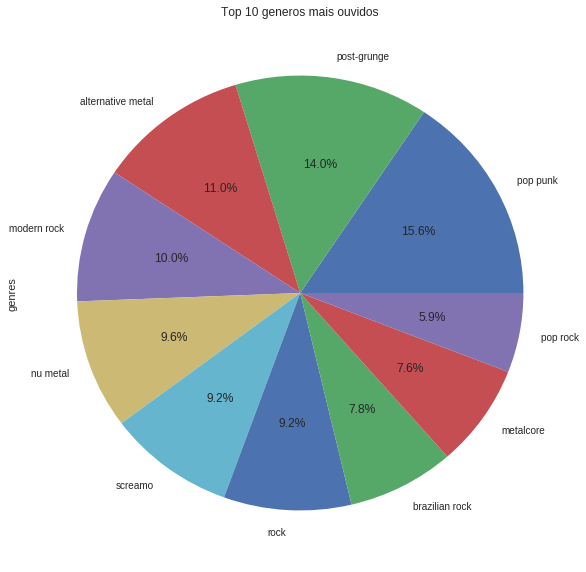

In [53]:
qtd_generos = pdgenres.genres.value_counts(ascending=False).head(10)
print(qtd_generos)
qtd_generos.plot(kind='pie', figsize=(10,10),autopct='%1.1f%%')
plt.title('Top 10 generos mais ouvidos')
plt.show()

Our Last Night         47
Maroon 5               35
Muse                   34
Boyce Avenue           34
Avenged Sevenfold      34
Supercombo             32
Eminem                 32
All Time Low           31
Imagine Dragons        30
Jimmy Eat World        29
Fall Out Boy           28
Twenty One Pilots      27
Panic! At The Disco    27
Asking Alexandria      27
Weezer                 26
Name: artist, dtype: int64


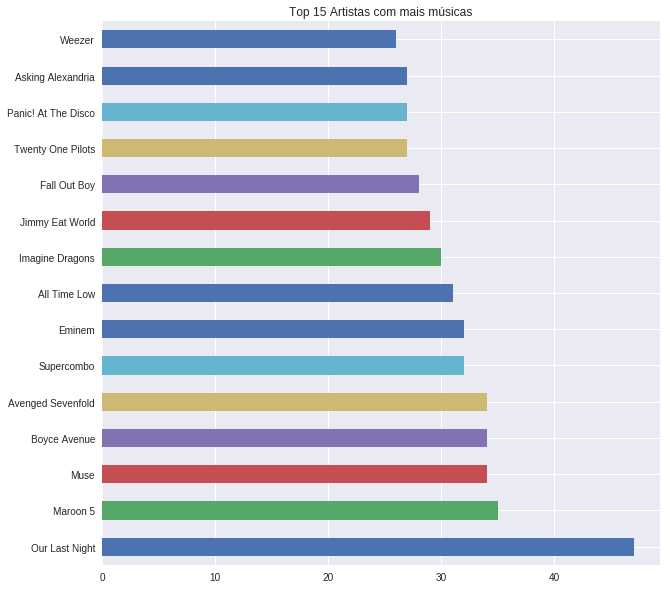

In [63]:
top_artists = pdmusics.artist.value_counts().head(15)
print(top_artists)
top_artists.plot(kind='barh', figsize=(10,10))
plt.title('Top 15 Artistas com mais músicas')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


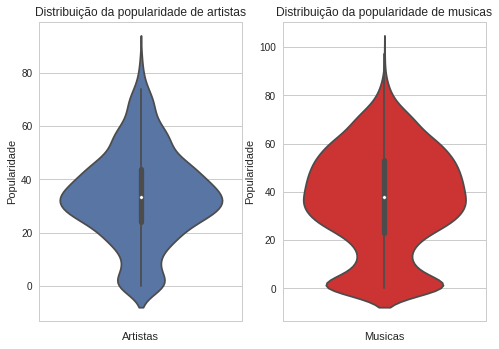

In [97]:
pop_artists = pdmusics.groupby('artist').popularity.mean().sort_values(ascending=False)
pop_artists.head(15)

sns.set(style="whitegrid")

plt.subplot(1,2,1)
sns.violinplot(y=pop_artists)
plt.title('Distribuição da popularidade de artistas')
plt.xlabel('Artistas')
plt.ylabel('Popularidade')

plt.subplot(1,2,2)
sns.violinplot(y='popularity', data=pdmusics, color='red', saturation=0.6)
plt.title('Distribuição da popularidade de musicas')
plt.xlabel('Musicas')
plt.ylabel('Popularidade')

plt.show()

In [0]:
mlist = get_user_playlists(spfy, '12144777067', features=True)
namelist = get_user_playlists(spfy, '12144777067')

In [56]:
musics = []
for playlist, tracks in namelist:
    for track in tracks:
        musics.append(track)
        
result = pd.DataFrame(mlist)
namedata = pd.DataFrame(musics)

alldata = pd.merge(result, namedata, how='left', on='id').drop_duplicates(subset='id')
alldata.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4163 entries, 0 to 7181
Data columns (total 15 columns):
acousticness        4163 non-null float64
danceability        4163 non-null float64
energy              4163 non-null float64
id                  4163 non-null object
instrumentalness    4163 non-null float64
key                 4163 non-null int64
liveness            4163 non-null float64
loudness            4163 non-null float64
mode                4163 non-null int64
speechiness         4163 non-null float64
tempo               4163 non-null float64
valence             4163 non-null float64
duration_ms         4163 non-null int64
name                4163 non-null object
popularity          4163 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 520.4+ KB


In [58]:
alldata = alldata.sample(frac=1)
alldata = alldata[:500]
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 3653 to 5960
Data columns (total 15 columns):
acousticness        500 non-null float64
danceability        500 non-null float64
energy              500 non-null float64
id                  500 non-null object
instrumentalness    500 non-null float64
key                 500 non-null int64
liveness            500 non-null float64
loudness            500 non-null float64
mode                500 non-null int64
speechiness         500 non-null float64
tempo               500 non-null float64
valence             500 non-null float64
duration_ms         500 non-null int64
name                500 non-null object
popularity          500 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 62.5+ KB


Text(0.5,1,'Correlações entre colunas')

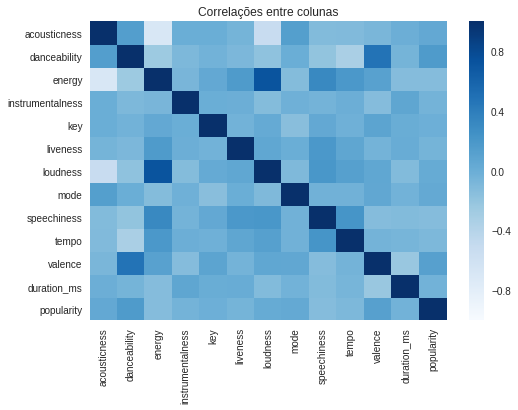

In [90]:
sns.heatmap(alldata.corr(), cmap='Blues')
plt.title('Correlações entre colunas')

In [95]:
alt.Chart(alldata).mark_point().encode(
    x='danceability',
    y='valence',
    tooltip='name',
)

Chart({
  data:       acousticness  danceability  energy                      id  \
  3653      0.017300         0.555   0.919  1W38GBgkkhzEtqevrED3CX   
  99        0.000048         0.409   0.992  7gYL9E5WN7Nd8l2ZQ1rkKI   
  5839      0.000299         0.542   0.991  7xK5Y4OyDBtbw9KDnUDLAU   
  6994      0.000130         0.469   0.738  2bZ7OXzULD6d6qr137kR83   
  4948      0.030200         0.796   0.840  04paQ37b9ea8jLFAPQrRMh   
  6958      0.720000         0.527   0.209  0ee40G4B8b2qjY0mWWc6ss   
  4782      0.703000         0.362   0.489  2opYFXG31JmbHuYTMs9J5a   
  6577      0.003600         0.558   0.813  6APnYxfLzIg2cejA3v2ljy   
  6891      0.040100         0.535   0.817  3DidITsxomLA3gz25FAlgz   
  2825      0.847000         0.682   0.175  2TmLZLv57mW4OA3Il1ULsf   
  1846      0.058300         0.688   0.835  546QTayX6j4GcZsfTRrVnL   
  2707      0.185000         0.405   0.957  4feOvmKAeCNERE0G0RtrRL   
  5915      0.526000         0.732   0.731  46qtEi9qJOXxmY0qel1wpN   
  5647      0.000178         0.462   0.936  3hY9sZmOZq4Zn6ZoDRBHwy   
  5832      0.000023         0.375   0.929  6S3MqV49f09I4IFwwhKR7B   
  6748      0.012200         0.591   0.941  3Oeg3i53vEsV8LDs7abeUj   
  3238      0.000242         0.303   0.868  7embDIZIv1Lzf6xF5UlEpA   
  3841      0.057200         0.585   0.776  5xEM5hIgJ1jjgcEBfpkt2F   
  4683      0.000570         0.264   0.882  5heRJEokcKygT588ZXjYXn   
  2909      0.028700         0.566   0.969  6L5QMBrydoaapTDMQ0Anui   
  2848      0.000171         0.480   0.938  6XuWU4lIzo6CiKtPhU7x21   
  3194      0.001930         0.418   0.909  4RF1d3ZGc9z4ogu0yXh5cb   
  3621      0.002930         0.919   0.657  5pBvNeOAJ54zgd5lEOmM3b   
  6121      0.001480         0.555   0.911  75SixhsPWyRRmtqHeffiXr   
  4959      0.043100         0.624   0.515  65hrQjcGvXuyarVCR5yLL6   
  244       0.000023         0.491   0.951  0NdidkH0EQwG7mx6F6SDkI   
  5645      0.056300         0.749   0.723  2nqwxzn7svkN30dVGbXdWf   
  5009      0.000724         0.417   0.981  4CB5fG583DEya75ZEqPYn6   
  1569      0.005740         0.579   0.508  4Vn7TykT27PIygBiZjTR2s   
  1222      0.002400         0.666   0.776  6rAXHPd18PZ6W8m9EectzH   
  ...            ...           ...     ...                     ...   
  1550      0.020400         0.488   0.862  6qpN7PrkVsP3N3xO7WlCaw   
  4837      0.003550         0.463   0.927  4pManxOg9vZ7YxkYILAIQP   
  5410      0.000102         0.565   0.986  6mbimqh0qdpNUvnhBYlhB3   
  2483      0.002210         0.424   0.878  47KVHb6cOVBZbmXQweE5p7   
  7156      0.000410         0.615   0.971  1Fh2sI7cLFe77LrjjhXBar   
  3431      0.008810         0.453   0.983  4pCiWJrTiAzkvSywAYd0Kf   
  5261      0.207000         0.423   0.491  3TzbmnFbIhJbUwzpAZIBkc   
  5243      0.000054         0.434   0.943  3VhJeuwU4OAYtRmjUrLTJK   
  2134      0.036800         0.509   0.584  6y20BV5L33R8YXM0YuI38N   
  5887      0.032700         0.607   0.934  7ElF5zxOwYP4qVSWVvse3W   
  2419      0.002970         0.515   0.853  2zfFLgnzc9PspmqKMODS2g   
  3608      0.001940         0.414   0.986  1AnHrytA5dLlTpioOamUiG   
  1170      0.002380         0.558   0.799  5j3iBuHq6vv7VcBo4Y2QrK   
  50        0.000020         0.370   0.971  2BjsztXjQDBjmL7PiKUbuL   
  726       0.006060         0.622   0.590  3zTTvo1kI9JNCvSFQ9RsCK   
  6805      0.236000         0.399   0.952  0w9HCom5v1vqXWOLYjlBqe   
  1740      0.013800         0.567   0.813  6D5pfooPP6hi99RaXjkDsP   
  4794      0.000209         0.515   0.917  6JSryEdVJTZq6YBn3wK2sn   
  2839      0.002130         0.365   0.978  36TEvN58A5fRN571FqmdI6   
  3455      0.000013         0.418   0.906  6hzwfFKrTabeUsW5SWti17   
  6302      0.000367         0.413   0.955  4JkAksOGGSferXHyr4qm7g   
  2903      0.001800         0.517   0.856  10Zq7rS6Fr3lKBIj0nnx7l   
  7041      0.000821         0.235   0.913  06KyZ0CaY369OSTRs2kOGj   
  4210      0.033000         0.509   0.846  0aJzrpwqEdGZQsSHLvbbpz   
  2883      0.000010         0.381   0.885  67vjRQhWgGBlsTZbpSnB8Y